# Exploratory Data Analysis (EDA): Under the Hood of Legal AI

Welcome to the **Research Lab**. As an AI Architect, the first step isn't coding—it's understanding the data. This notebook bridges the gap between raw legal text and a high-performance machine learning model.

##  AI Foundations: What are we doing?

### 1. Traditional Programming vs. AI
- **Traditional Programming**: We write rules (`if word == "liability": risk = high`). But contracts are too complex for millions of `if` statements.
- **AI/Machine Learning**: We show the computer 20,000 examples of "Risk" vs "No Risk" and let it develop its own mathematical intuition.

### 2. The Classification Task
We are performing **Binary Classification**. Our target variable is `clause_status`:
- `0`: Low Risk (Standard operational language)
- `1`: High Risk (Obligations, liabilities, and legal triggers)

### 3. NLP Fundamentals: TF-IDF
Computers don't "read"; they calculate. We use **TF-IDF (Term Frequency-Inverse Document Frequency)** to turn words into numbers. It highlights words that are frequent in a specific clause but rare across the whole contract (like "Indemnify"), making them strong signals for our AI.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer

# Set project style - Making it look professional
plt.style.use('fivethirtyeight')
sns.set_palette("magma")
plt.rcParams['figure.figsize'] = (12, 6)

##  1. Data Ingestion & Health Check
Before analysis, we must ensure our data is clean. Missing values (NaNs) are the "kryptonite" of Machine Learning.

In [25]:
df = pd.read_csv('../data/legal_docs_modified.csv')

# --- Data Scientist Health Check ---
print(" Dataset Shape:", df.shape)
print("\n Missing Value Analysis:")
print(df.isnull().sum())

# Cleaning: Removing empty clauses
df = df.dropna(subset=['clause_text'])
print(f"\n Cleaned Rows: {len(df)}")
df.head()

 Dataset Shape: (21187, 6)

 Missing Value Analysis:
Unnamed: 0        0
clause_text      43
clause_type       0
totalwords       26
totalletters     26
clause_status     0
dtype: int64

 Cleaned Rows: 21144


,Unnamed: 0,clause_text,clause_type,totalwords,totalletters,clause_status
0,0,"Make any Investments, except:",investments,4.0,30.0,0
1,1,No more than 45% of the “value” (as defined i...,investments,76.0,460.0,0
2,2,"Make or hold any Investments, except:",investments,6.0,38.0,0
3,3,The SubAdviser is hereby authorized and direc...,investments,228.0,1474.0,1
4,4,"Make any advance, loan, extension of credit (...",investments,52.0,329.0,0


##  2. Clause Length Analysis
**Hypothesis**: High-risk legal clauses are often longer because they require precise, verbose language to define obligations.

We calculate the length (number of characters) for every clause.

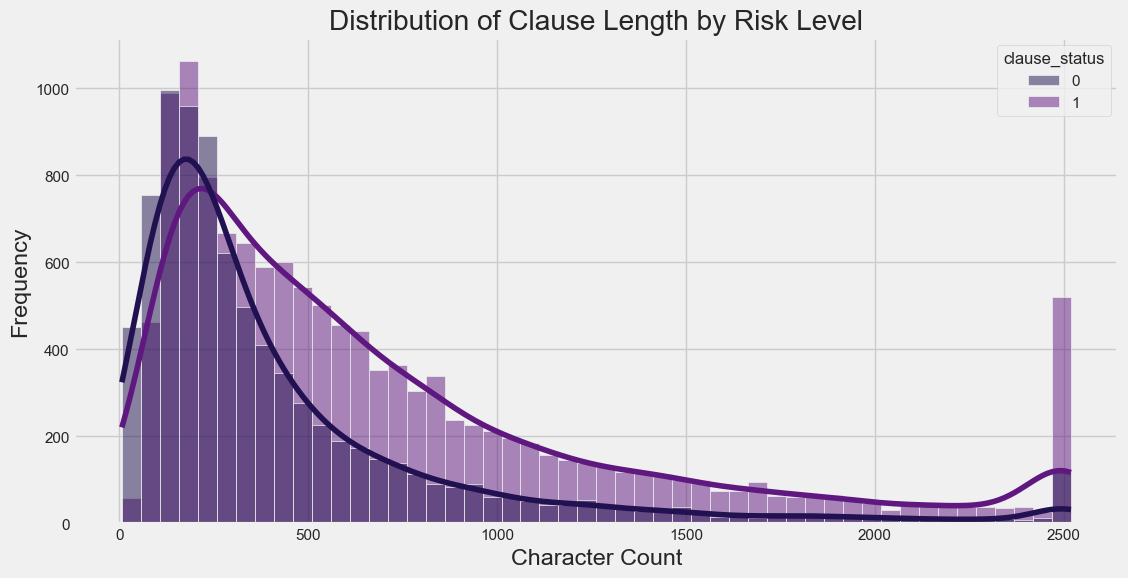


 Average Length by Risk:
clause_status
0    436.008165
1    717.626170
Name: char_length, dtype: float64


In [26]:
df['char_length'] = df['clause_text'].astype(str).apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='char_length', hue='clause_status', kde=True, bins=50)
plt.title('Distribution of Clause Length by Risk Level')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

print("\n Average Length by Risk:")
print(df.groupby('clause_status')['char_length'].mean())

 **Insight**: If the distribution peaks are different, length is a valid feature for our model!

##  3. Risk Label Distribution
**Theory**: In many real-world datasets, we face **Class Imbalance** (e.g., more Low Risk than High Risk). If the AI only sees Low Risk, it won't recognize danger.

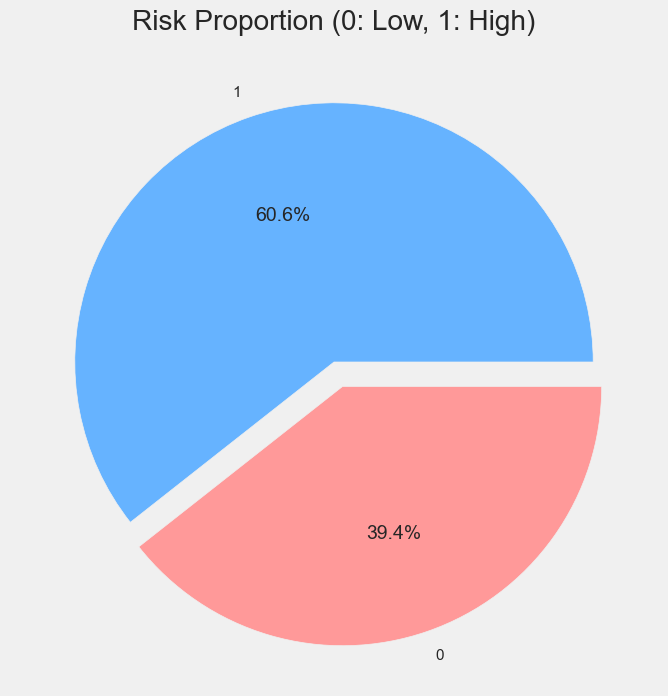

In [27]:
colors = ['#66b3ff', '#ff9999']
plt.figure(figsize=(8, 8))
df['clause_status'].value_counts().plot.pie(autopct='%1.1f%%', colors=colors, explode=[0, 0.1])
plt.title('Risk Proportion (0: Low, 1: High)')
plt.ylabel('')
plt.show()

##  4. Feature Importance: The Power of Words
Using TF-IDF, we can identify which words "own" certain risk categories.

In [28]:
def get_top_tfidf_features(risk_level, n=15):
    subset = df[df['clause_status'] == risk_level]['clause_text']
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(subset)
    
    # Sum weights across all documents
    weights = tfidf_matrix.sum(axis=0).A1
    feature_names = vectorizer.get_feature_names_out()
    
    # Create sorted dataframe
    result = pd.DataFrame({'word': feature_names, 'score': weights})
    return result.sort_values(by='score', ascending=False).head(n)

print(" Top Signal Words for HIGH RISK (1):")
print(get_top_tfidf_features(1))

print("\n Top Signal Words for LOW RISK (0):")
print(get_top_tfidf_features(0))

 Top Signal Words for HIGH RISK (1):
           word       score
868       shall  968.551554
72    agreement  818.954019
191     company  695.317442
837      salary  404.244895
265        date  390.361968
123        base  372.749540
660       party  355.332514
937        time  349.532201
369   executive  329.632618
927       terms  296.448045
497  investment  295.063136
846     section  286.860692
752        rate  277.340352
665     payment  275.612890
138    borrower  253.378353

 Top Signal Words for LOW RISK (0):
              word       score
222        company  608.289153
97       agreement  532.613080
874         shares  428.251360
529     investment  382.714797
894          stock  340.770099
678        parties  257.618765
67             act  204.855823
899        subject  194.969225
434        follows  192.425442
235  consideration  192.331644
848        section  181.541690
296           date  180.643220
439          forth  178.422674
867            set  174.728819
538         i

## 🧪 5. Unsupervised Discovery (Clustering Demo)
**Theory**: clustering is **Unsupervised Learning**. We don't tell the AI what the labels are; we just ask it to find similar groups. This helps us see if legal clauses naturally separate into their types (e.g., Termination vs Liability).

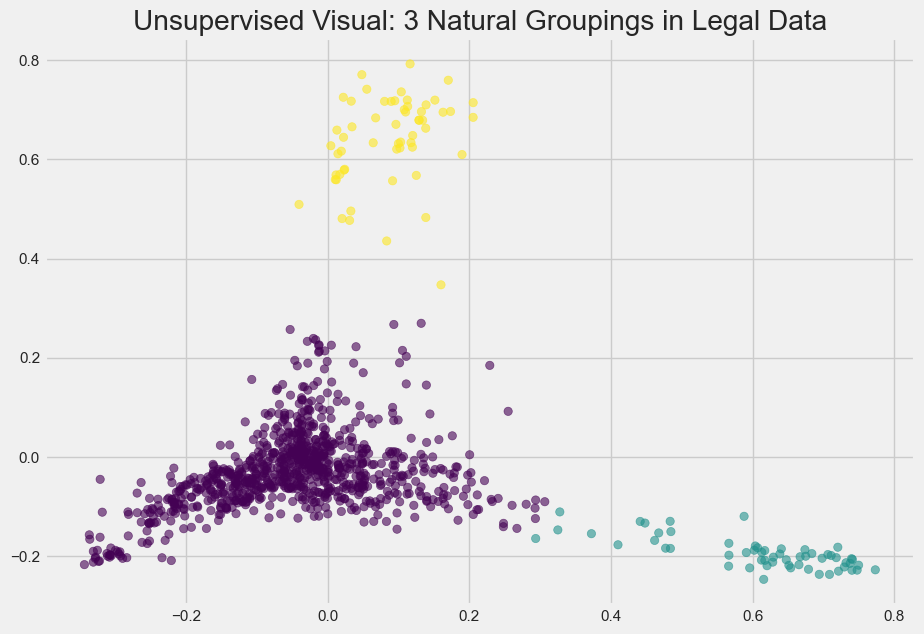

In [29]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Sample data for speed
sample_df = df.sample(1000, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(sample_df['clause_text'])

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
scatter_data = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(scatter_data[:, 0], scatter_data[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Unsupervised Visual: 3 Natural Groupings in Legal Data')
plt.show()

##  Conclusion & Next Steps

Through this EDA, we've confirmed:
1. Our data has **class imbalance**, so we need balanced model weights.
2. **Feature separation** exists (high risk has different keywords than low risk).
3. **Unsupervised clusters** show that legal text naturally groups into patterns.

Now, we are ready to teach our **brain** using Logistic Regression!